<h1><center>Stroke Prediction</center></h1>
<center>September 2024</center>
<center>Celine Ng</center>

# Table of Contents

1. Project Introduction   
    1. Notebook Preparation
    1. Motivation and Objectives
    1. Dataset
1. Data Cleaning
    1. Duplicate rows
    1. Datatypes
    1. Unique values
    1. Missing values
1. EDA
    1. Distribution
    1. Distribution according to target label
    1. Missing Values
    1. Statistic Inference
        1. Target Population
        2. Transform 'AnnualIncome'
       3. Hypothesis Testing
1. Data Formatting
1. Preprocessing
    1. Transformations
    1. Data Splitting
1. Models
    1. Basic model
    1. Baseline model
    1. Hyperparameter Tuning
1. Conclusion
1. Improvements

# 1. Project Introduction

## 1.1. Notebook Preparation

In [46]:
%%capture
%pip install -r requirements.txt

In [95]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.eda import *
from utils.model import *

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     cross_validate, GridSearchCV)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             precision_score, recall_score, make_scorer)

## 1.2. Motivations and Objectives

This project's objectives are: 
<br><br>
1. Practice performing EDA.
2. Practice applying statistical inference procedures.
3. Practice using various types of machine learning models.
4. Practice building ensembles of machine learning models.
5. Practice deploying machine learning models.

## 1.3. Dataset

Objective: Brief overview of our dataset, including the features and label

The dataset was downloaded from Kaggle, [Stroke_Prediction_Data](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)
,<br>
on 10 September 2024. It will be used to predict whether a patient is likely
 <br> to get a stroke. <br>
The data contains 11 clinical features, like gender, age, smoking status, <br>
etc, that help describe each patient.

Features: <br>
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
<br>

Label: <br>
stroke: 1 if the patient had a stroke or 0 if not <br>

In [48]:
stroke_data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
display(stroke_data.head())
shape = stroke_data.shape
print(f'Number of rows: {shape[0]}\nNumber of columns: {shape[1]}')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Number of rows: 5110
Number of columns: 12


# 2.  Data cleaning
Objective:
1. Closer look at the values that consist of our data
2. Look out for duplicates, and missing and/or unusual values

## 2.1. Duplicate rows

In [49]:
print(stroke_data.id.duplicated().any())

False


After confirming there is no duplicated id number/cases, since id number 
should not be relevant information to base our prediction on, we can remove it.

In [50]:
stroke_data = stroke_data.drop(columns=['id'])

## 2.2. Datatypes

In [51]:
datatype_data = stroke_data.dtypes
datatype_data

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Certain features have unexpected datatypes, like age, hypertension, and 
heart_disease. Looking into the values itself will help clarify data types.

## 2.3. Unique values

In [52]:
stroke_data.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

Some features have unexpected amount of unique values. Looking into the 
values itself will help.<br>

In [53]:
for column in stroke_data.columns:
    df = stroke_data[column].value_counts()
    display(df)

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

age
78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: count, Length: 104, dtype: int64

hypertension
0    4612
1     498
Name: count, dtype: int64

heart_disease
0    4834
1     276
Name: count, dtype: int64

ever_married
Yes    3353
No     1757
Name: count, dtype: int64

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

avg_glucose_level
93.88     6
91.68     5
91.85     5
83.16     5
73.00     5
         ..
111.93    1
94.40     1
95.57     1
66.29     1
85.28     1
Name: count, Length: 3979, dtype: int64

bmi
28.7    41
28.4    38
26.7    37
27.6    37
26.1    37
        ..
48.7     1
49.2     1
51.0     1
49.4     1
14.9     1
Name: count, Length: 418, dtype: int64

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

stroke
0    4861
1     249
Name: count, dtype: int64

Looking more into work_type registered as 'children', as the difference 
between 'children' and 'Never_worked' is not clear.

In [54]:
stroke_data[stroke_data.work_type=='children'].age.describe()

count    687.000000
mean       6.841339
std        4.533364
min        0.080000
25%        2.000000
50%        6.000000
75%       11.000000
max       16.000000
Name: age, dtype: float64

All labeled as children are <= 16 years old.

In [55]:
stroke_data[(stroke_data.age<=16)]['work_type'].value_counts()

work_type
children         687
Private           85
Never_worked      12
Self-employed      9
Govt_job           3
Name: count, dtype: int64

It is clear that not all under 16 year olds are labeled as 'children'. Some 
are 'Never_worked', and some are working. It is unclear why only part is 
labeled as 'children'. <br>However, it since this
 feature is to state their work status and 'children' in this context would 
 mean not working, we can consolidate 'children' into 'Never_worked'. <br>
 This would ensure consistency across all age groups, without losing the age
  information, as it is in the 'age' column.

In [56]:
stroke_data.loc[stroke_data['work_type'] == 'children', 'work_type'] = \
    'Never_worked'

## 2.4. Missing values

In [57]:
missing_values(df=stroke_data)

,Column,Missing Values,Percentage Missing
gender,gender,0,0.00
age,age,0,0.00
hypertension,hypertension,0,0.00
heart_disease,heart_disease,0,0.00
ever_married,ever_married,0,0.00
work_type,work_type,0,0.00
Residence_type,Residence_type,0,0.00
avg_glucose_level,avg_glucose_level,0,0.00
bmi,bmi,201,3.93
smoking_status,smoking_status,0,0.00


To properly impute missing values, it is necessary to first understand the 
sampling population and if the missing values belong to a specific subset of
 sampling population.

In [58]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Data Cleaning Insights:</b><br>
    1. There are no duplicated rows, and each row is identified by a unique ID.<br>
    2. The feature 'id' is irrelevant to our stroke prediction, so it was removed.<br>
    3. Consolidated 'children' work type to 'Never_worked'. <br>
    4. All missing values come from the 'bmi' feature, and further analysis 
    is needed to determine proper imputation methods.
</div>
''')

# 3. EDA

Objectives:
1. Data distribution
2. Check and handle outliers, missing values
3. Comparison between data with and without stroke
4. Understand how our data was collected and possible bias
5. Understand how do columns related with each other - correlation
6. 

## 3.1. Distribution

Identify features, label, and different feature types.

In [59]:
target_name = 'stroke'
data, target = (stroke_data.drop(columns=[target_name]), 
                stroke_data[target_name])

In [60]:
categorical_columns_selector = selector(dtype_exclude='float64')
numerical_columns_selector = selector(dtype_include='float64')

categorical_columns = categorical_columns_selector(data)
numerical_columns = numerical_columns_selector(data)

**Numerical Features**

In [61]:
data[numerical_columns].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


Plotting boxplot over violin plot for numerical features to have a visual 
understanding of the overall distribution, range, and outliers.

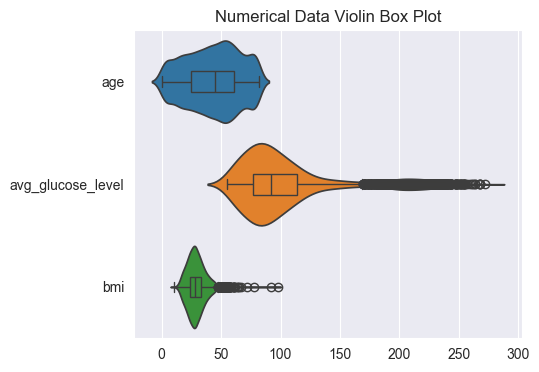

In [62]:
plt.figure(figsize=(5,4))
violin_boxplot(data=data, columns=numerical_columns, title='Numerical Data '
                                                           'Violin Box '
                                                           'Plot')
plt.show()

**Categorical Features**

In [63]:
categorical_columns

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status']

Represent categorical features in barplots, visualize unique values for each
 feature and their distribution in percentage.

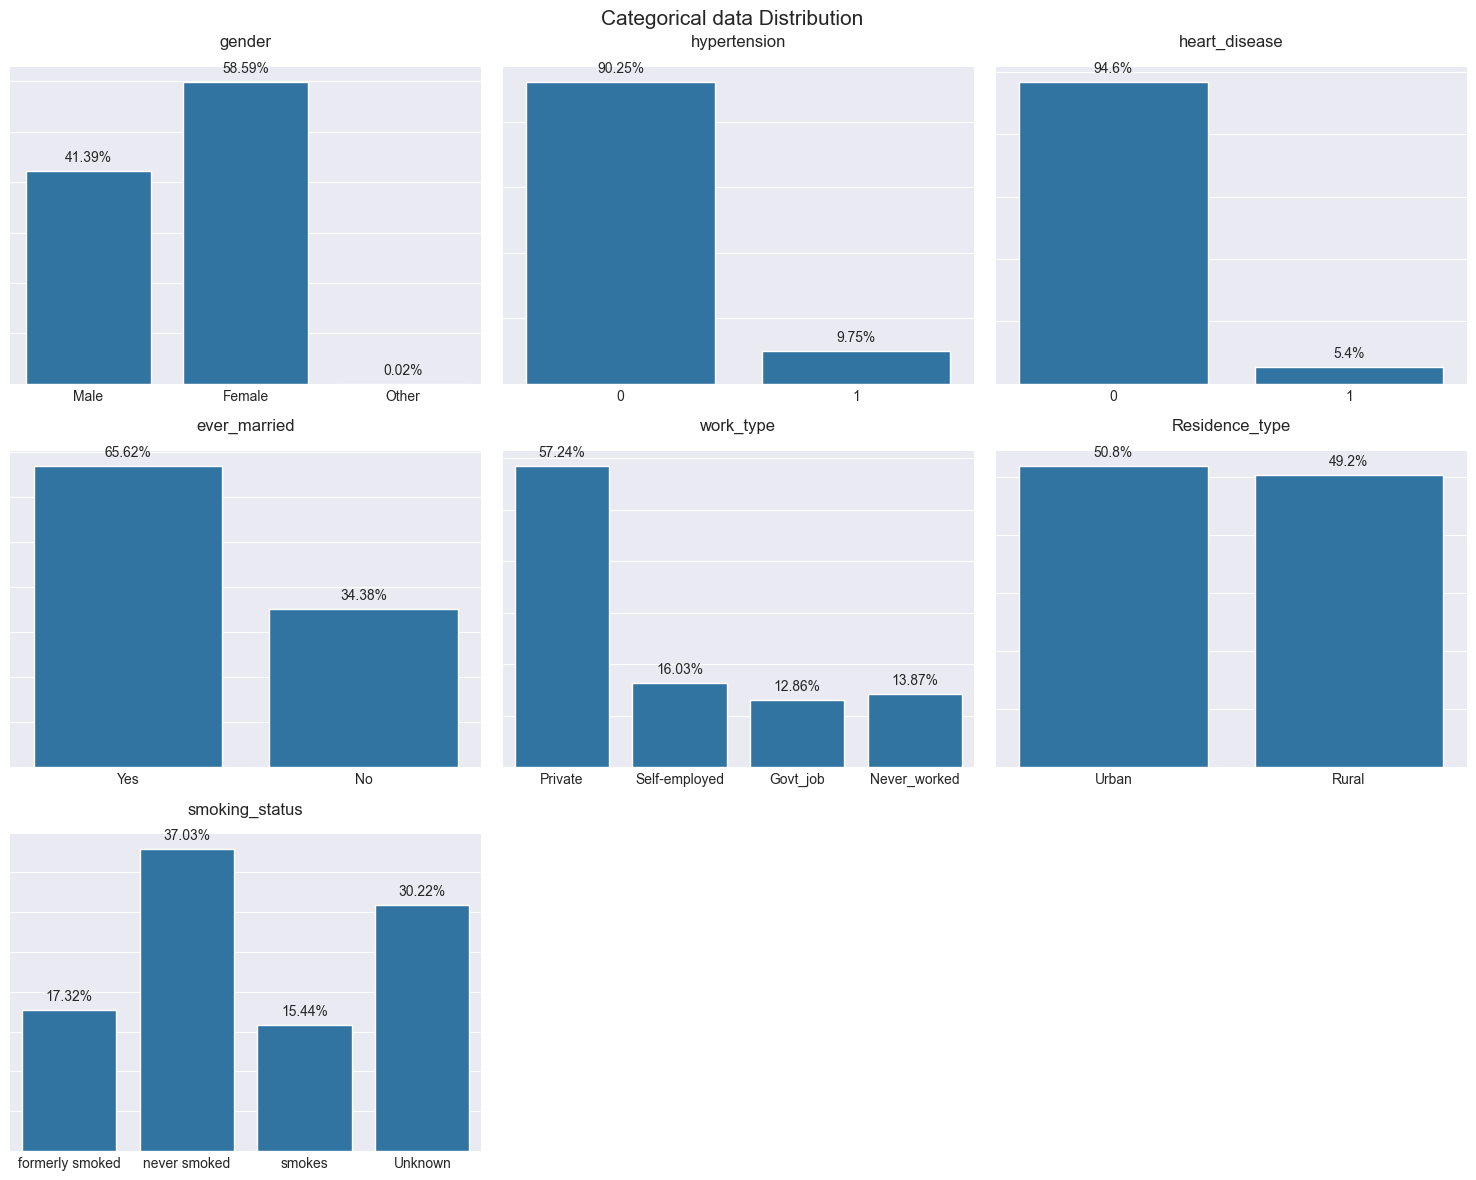

In [64]:
percentage_subplots(data=data, columns=categorical_columns, title='Categorical '
                                                             'data '
                                                             'Distribution',
               nrows=3, ncols=3)

**Target Variable**

Target variable and its distribution in percentage.

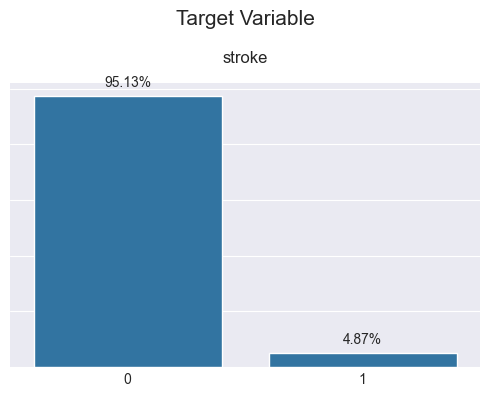

In [65]:
percentage_subplots(data=stroke_data, columns=['stroke'], title='Target Variable')

In [66]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Distribution Insights:</b><br>
    <i>numerical features...</i><br>
    1. Numerical features show very different ranges of values, signalling an 
    importance in scaling in future feature engineering.<br>
    2. Average Glucose Level has the most outliers, which can be justified 
    by the bimodal distribution. This could contain relevant information to 
    our target prediction.
    <br>
    3. 'age' includes children less than 1 year old, justifies why the 
    datatype is float.<br><br>
    
    <i>for categorical features...</i><br>
    4. Inconsistent labeling among categorical features, preprocessing 
    required before applying learning model.<br>
    5. Outlier responses in 'gender'.<br><br>
    
    <i>and the target variable...</i><br>
    6. Imbalanced dataset, with only 4.87% responding positively to stroke. 
    <br>
</div>
''')

In [67]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Target Population:</b><br>
    The target population is mostly likely the group of people who are 
    concerned about their probability of getting a stroke.<br><br>
    
    <b>Sampling Population:</b><br>
    Our data's distribution describes our sampling population. 
    <br><br>
    
    <b>Potential Bias:</b><br>
    The data's collection method and answer's definition are unknown. 
    If the sampling population is not representative of the target 
    population, there might be significant biases. 
    <br>
</div>
''')

## 3.2. Distribution according to target label
Objective:<br>
Plot data distribution by target variable to understand if the populations 
show clear differences in their characteristics.

**Numerical Features** <br>
Cases with stroke

In [68]:
stroke_data[stroke_data.stroke == 1][numerical_columns].describe()

,age,avg_glucose_level,bmi
count,249.000000,249.000000,209.000000
mean,67.728193,132.544739,30.471292
std,12.727419,61.921056,6.329452
min,1.320000,56.110000,16.900000
25%,59.000000,79.790000,26.400000
50%,71.000000,105.220000,29.700000
75%,78.000000,196.710000,33.700000
max,82.000000,271.740000,56.600000


Cases without stroke

In [69]:
stroke_data[stroke_data.stroke == 0][numerical_columns].describe()

,age,avg_glucose_level,bmi
count,4861.000000,4861.000000,4700.000000
mean,41.971545,104.795513,28.823064
std,22.291940,43.846069,7.908287
min,0.080000,55.120000,10.300000
25%,24.000000,77.120000,23.400000
50%,43.000000,91.470000,28.000000
75%,59.000000,112.830000,33.100000
max,82.000000,267.760000,97.600000


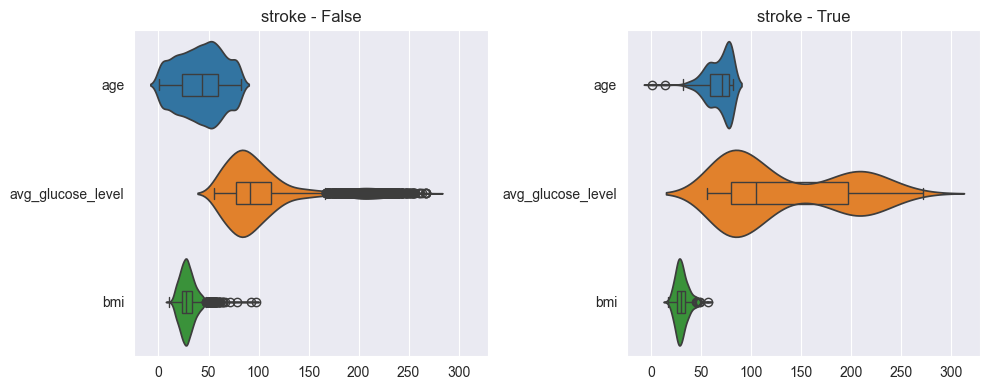

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True)

violin_boxplot(data=stroke_data[stroke_data.stroke == 1], 
               columns=numerical_columns, title='stroke - True', ax=axes[1])
violin_boxplot(data=stroke_data[stroke_data.stroke == 0], 
               columns=numerical_columns, title='stroke - False', ax=axes[0])

plt.tight_layout()
plt.show()

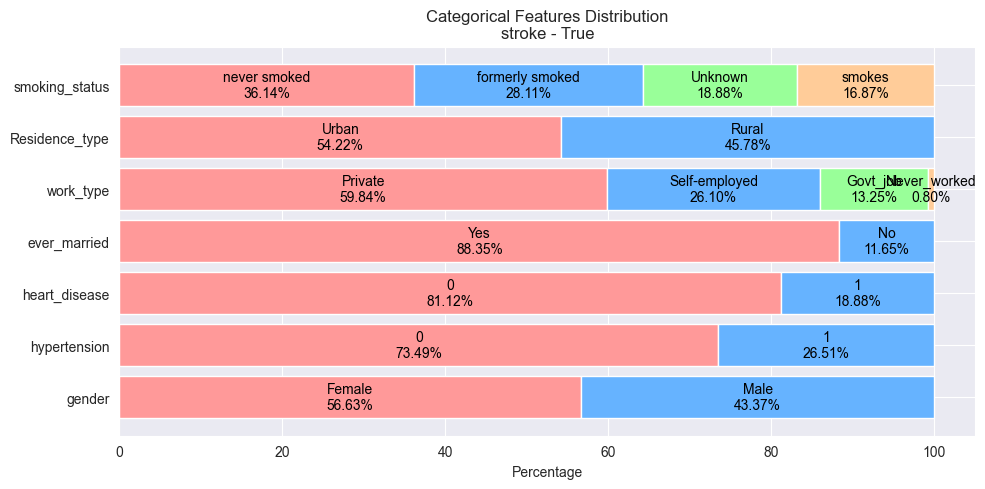

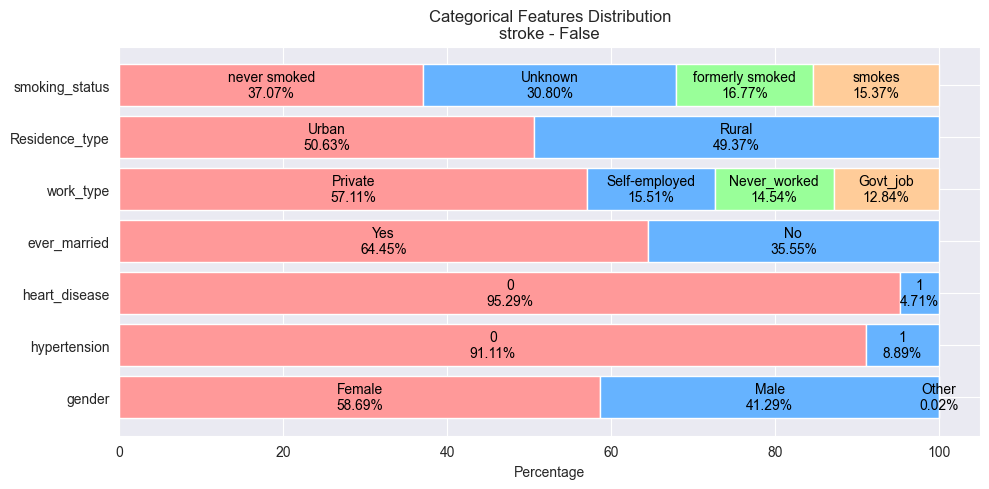

In [71]:

stacked_horizontal_feature_distribution(data=stroke_data[stroke_data.stroke == 1], 
                                        columns=categorical_columns, 
                                        title='Categorical Features '
                                              'Distribution\nstroke'
                                              ' - True') 
stacked_horizontal_feature_distribution(data=stroke_data[stroke_data.stroke == 0], 
               columns=categorical_columns, title='Categorical Features '
                                              'Distribution\nstroke - False')

In [72]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Distribution Insights:</b><br>
    Plots show visually significant difference between population with and 
    without stroke.<br><br>
    <i>numerical features...</i><br>
    1. With stroke consists of a higher age and higher bmi mean, with a 
    smaller standard deviation. Considering the sample size is smaller for 
    cases with stroke, it is very possible that these 2 features are highly 
    predictive of our target variable.<br>
    2. Average Glucose Level for cases with stroke has both the higher mean 
    and higher standard deviation. This is likely due to its clear 
    bimodal distribution. <br><br>

    
    <i>for categorical features...</i><br>
    3.  Smoking status, residence type, and gender seem similar among both 
    target labels. This could mean these features do not contain predictive 
    information for the target variable.<br>
    4. Work type, ever married, heart disease, and hypertension show 
    more different distribution.<br>
    5. Knowing that age seem to be an important factor, important to note 
    that some other features are also highly influenced by age. For example,
     it is more likely for the older age group to have a higher ratio to have 
    ever been married, or worked. <br>
</div>
''')

## 3.3. Missing values

Objective: <br>
All missing values come from the 'bmi' feature. Determine proper treatment.

Plot data distribution of cases with missing bmi values. Compare to the 
original data distributions, and check if there is a clear difference 
with missing bmi cases.

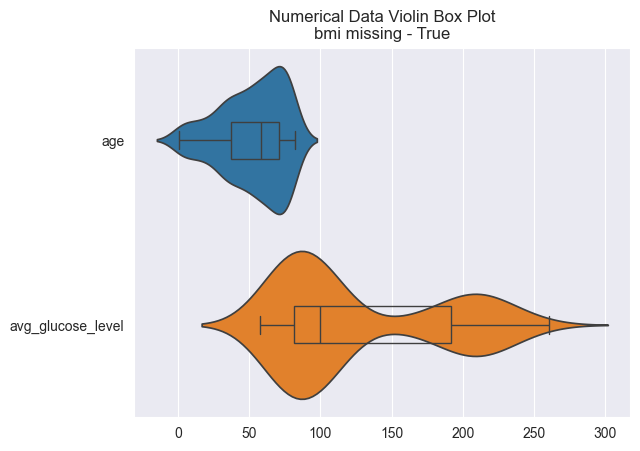

In [73]:
violin_boxplot(data=stroke_data[stroke_data.bmi.isnull()], 
               columns=['age', 'avg_glucose_level'],
               title='Numerical Data Violin Box Plot\nbmi missing - True')

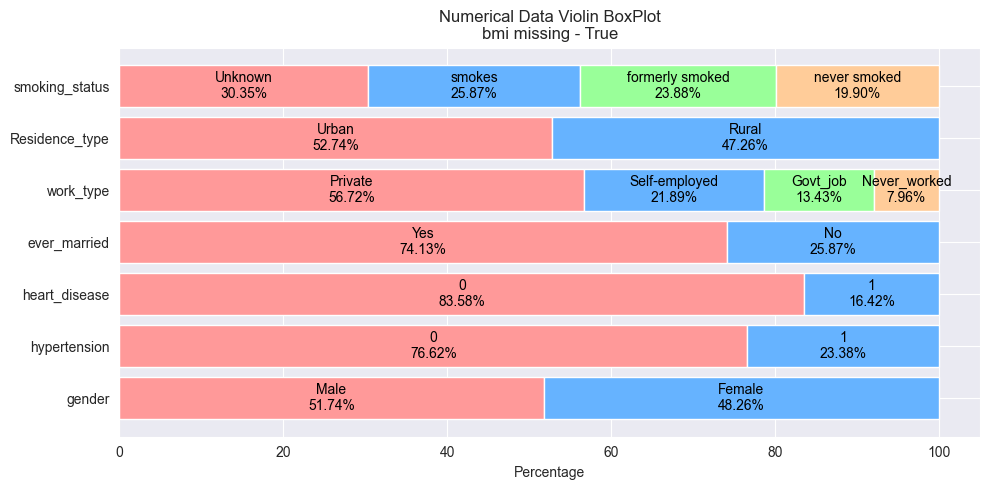

In [74]:
stacked_horizontal_feature_distribution(data=stroke_data[stroke_data.bmi.isnull()], 
                                        columns=categorical_columns, 
                                        title='Numerical Data Violin Box'
                                              'Plot\nbmi missing - True')

The distribution for both numerical and categorical do not seem to represent
 a different subpopulation. <br>
Check if bmi is correlated with other features, this can help choose what 
values to impute.

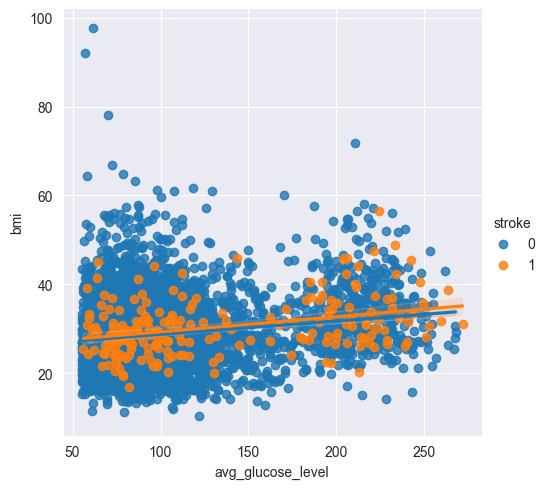

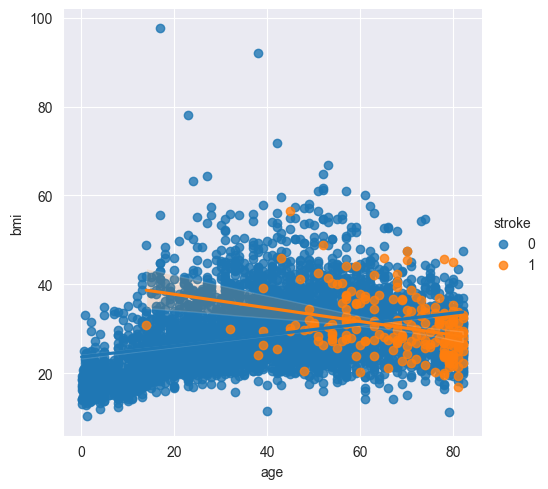

In [75]:
sns.lmplot(data=stroke_data, x='avg_glucose_level', y='bmi', hue='stroke')
sns.lmplot(data=stroke_data, x='age', y='bmi', hue='stroke')

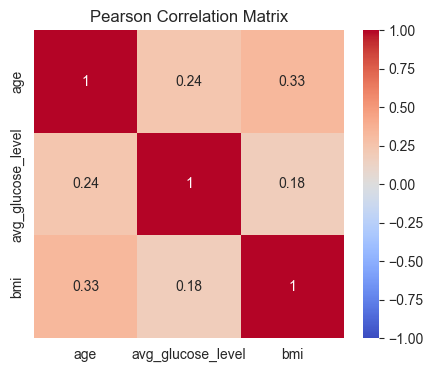

In [76]:
correlation_matrix = stroke_data[numerical_columns].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            center=0)
plt.title('Pearson Correlation Matrix')
plt.show()

From the plots above: <br>
1. Correlation between numerical features are very weak to weak.
2. bmi values could be imputed by linear interpolation from other numerical 
features. Since correlation coefficient is low, using mean imputation or 
leaving it as null values is also good enough.

In [77]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Missing Values Insights:</b><br>
    After some analysis, it is understood that missing values do not belong 
    to any specific subpopulation. The subset of data which has missing 
    'bmi' values do not show a drastically different distribution in other 
    features. Therefore, imputing with the mean value, or even keeping it as
    null value during the preprocessing step will be enough.
</div>
''')

# 4. Data Formatting
Objective: Only decision tree based models will be used in this project, 
so the following formatting is only to be able to draw a tree visually, 
providing with better interpretability in the end.

Remove all empty values in values.

In [78]:
stroke_data['smoking_status'] =(
    stroke_data['smoking_status'].replace(' ', '_', regex=True))
stroke_data['smoking_status'].unique()

array(['formerly_smoked', 'never_smoked', 'smokes', 'Unknown'],
      dtype=object)

Set empty values to 0 

In [79]:
stroke_data['bmi'] = stroke_data['bmi'].fillna(0)

# 5. Preprocessing
Objective:<br>
Prepare preprocesses in order to apply learning models. <br>
1. Data splitting
2. Data transformation and encoding

## 5.1. Data Splitting

In [80]:
X = data
y = target

Split data into train, validation, and test sets. With a ratio of 20% being 
the test set.

In [81]:
X_train_val, X_test, y_train_val, y_test =\
    train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

To evaluate variability of our estimation of the performance, cross 
validation will be used. More specifically, Stratified KFold, for the train 
and validation sets, as this is a better option for imbalanced and 
small datasets. 

In [82]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

## 5.2. Data Transformation

As only models based on decision trees will be used in this project, 
transformations like scaling and normalizing will not be needed. Only encoding 
categorical columns will be necessary.

**Define columns**

In [83]:
multicat_columns = ['gender', 'work_type', 'smoking_status']
binary_columns = ['hypertension', 'heart_disease', 'ever_married', 
                 'Residence_type']

**Define preprocessors for each type of data**<br>
LabelEncoder does not work within a pipeline, write our own function.

In [84]:
multicat_preprocessor = OneHotEncoder(handle_unknown='ignore')
binary_preprocessor = FunctionTransformer(binary_label_encoding)

**Bundle preprocessing for all data**

In [85]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', multicat_preprocessor, multicat_columns),
        ('binary', binary_preprocessor, binary_columns),
        ('passthrough', 'passthrough', numerical_columns)
    ]
)

# 6. Models
Objective: <br>
1. Apply and hyperparameter tuning machine learning models
2. Assess and select the best model

**Models**
1. Random forest classifier
2. XGBoost gradient boosted trees
3. LightGBM histogram gradient boosting

In [86]:
random_forest = RandomForestClassifier(random_state=0)
clf_xbg = xgb.XGBClassifier(objective='binary:logistic', missing=0, 
                            random_state=0)
clf_lgb = lgb.LGBMClassifier(objective='binary', random_state=0)

**Pipeline**

In [87]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', random_forest)
])

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf_xbg)
])

pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf_lgb)
])

## 6.1. Basic model
Objective: Fit and evaluate the basic model with default parameters to gain 
intuition on what improvements need to be made.

In [88]:
cv_results_rf = cross_validate(
    pipeline_rf, X_train_val, y_train_val, cv=skf,
    scoring=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'],
    return_train_score=True, n_jobs=2
)

cv_results_xgb = cross_validate(
    pipeline_xgb, X_train_val, y_train_val, cv=skf,
    scoring=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'], 
    return_train_score=True, n_jobs=2
)

cv_results_lgb = cross_validate(
    pipeline_lgb, X_train_val, y_train_val, cv=skf,
    scoring=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'], 
    return_train_score=True, n_jobs=2
)

print(f"cv_results_rf{cv_results_rf}")
print(f"cv_results_xgb{cv_results_xgb}")
print(f"cv_results_lgb{cv_results_lgb}")

cv_results_rf{'fit_time': array([0.15843892, 0.15527773, 0.14432812, 0.14472985, 0.16730404]), 'score_time': array([0.01820707, 0.01901913, 0.01639915, 0.01668215, 0.01696706]), 'test_roc_auc': array([0.8125144 , 0.75744709, 0.83646029, 0.79635489, 0.76616571]), 'train_roc_auc': array([1., 1., 1., 1., 1.]), 'test_accuracy': array([0.94865526, 0.95110024, 0.95476773, 0.94859241, 0.94859241]), 'train_accuracy': array([1.        , 1.        , 1.        , 1.        , 0.99969428]), 'test_precision': array([0.  , 0.  , 0.75, 0.2 , 0.  ]), 'train_precision': array([1., 1., 1., 1., 1.]), 'test_recall': array([0.        , 0.        , 0.07692308, 0.02564103, 0.        ]), 'train_recall': array([1.        , 1.        , 1.        , 1.        , 0.99358974]), 'test_f1': array([0.        , 0.        , 0.13953488, 0.04545455, 0.        ]), 'train_f1': array([1.        , 1.        , 1.        , 1.        , 0.99678457])}
cv_results_xgb{'fit_time': array([0.06240582, 0.06232381, 0.08998013, 0.08996987, 0

In [89]:
df_rf = pd.DataFrame(cv_results_rf).mean().to_frame('Random Forest')
df_xgb = pd.DataFrame(cv_results_xgb).mean().to_frame('XGBoost')
df_lgb = pd.DataFrame(cv_results_lgb).mean().to_frame('LightGBM')

results_df = pd.concat([df_rf, df_xgb, df_lgb], axis=1)
results_df

,Random Forest,XGBoost,LightGBM
fit_time,0.154016,0.071836,0.353279
score_time,0.017455,0.009884,0.010882
test_roc_auc,0.793788,0.805970,0.821178
train_roc_auc,1.000000,1.000000,0.999998
test_accuracy,0.950342,0.943248,0.944471
train_accuracy,0.999939,0.999817,0.999327
test_precision,0.190000,0.230159,0.206667
train_precision,1.000000,1.000000,1.000000
test_recall,0.020513,0.087179,0.066667
train_recall,0.998718,0.996154,0.985897


In [90]:
HTML('''
<div class="alert alert-block alert-info">
 <b>Fit and Score Time:</b><br>
    XGBoost is also the fastest in terms of score time, followed by 
LightGBM, and Random Forest is slightly slower. XGBoost and LightGBM are 
designed with optimizations that make predictions very fast, which explains 
why their scoring times are lower than Random Forest. LightGBM is also 
efficient but may benefit from more tuning, as its fit and score time are 
unexpectedly higher than XGBoost. <br><br>
<b>Test Scores:</b><br>
<i>For a problem like ours where main goal is to predict 
whether a person is likely or not to have stroke, it is preferable to have 
more FALSE POSITIVES than FALSE NEGATIVES.</i><br>
1. Accuracy: In our dataset due to how imbalanced it is, accuracy is not a good
indicator to rely on. <br>
2. Precision: This metric represents the accuracy of the positive 
predictions. This value is consistently low on all models, being 0.23 from 
XGBoost the highest. Considering the nature of the problem, this is not a 
huge issue. <br>
3. Recall: This is one of the most important metric in our case, as it 
captures how often the model correctly identifies a case with stroke from all 
cases with stroke. Currently this value is extremely low on all models.<br>
4. Area under the curve (AUC ROC): This metric measures how well the model 
distinguishes between positive and negative cases. LightGBM has the best 
results of all 3.<br>
5. F1 Score: This metric balances how well both recall and precision scored.
 Even though precision is not the focus of our problem, it is still ideal to
  have a model which performs better on both. And it is currently scoring 
  low on all models.
</div>
''')

## 6.2. Baseline model
Objective: Our dataset is very imbalanced, more than 95% of data belongs to 
no stroke (0). If the model simply predicted every case with no stroke, it 
would still get a very high score. Therefor, we will compare obtained scores
 to this baseline, to understand how much better actually are the models.

In [96]:
baseline_model = DummyClassifier(strategy='constant', constant=0)

baseline_results = cross_validate(
    baseline_model, X_train_val, y_train_val, cv=skf, 
    scoring={
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': 'recall',
        'f1': make_scorer(f1_score, zero_division=0)
    }, 
    return_train_score=True, n_jobs=2
)
baseline_df = pd.DataFrame(baseline_results).mean().to_frame('Baseline')
baseline_df

,Baseline
fit_time,0.001888
score_time,0.005563
test_roc_auc,0.500000
train_roc_auc,0.500000
test_accuracy,0.952299
train_accuracy,0.952299
test_precision,0.000000
train_precision,0.000000
test_recall,0.000000
train_recall,0.000000


In [99]:
HTML('''
<div class="alert alert-block alert-info">
 <b>Baseline Model:</b><br>
 As expected, if the model predicted all values to be 0, no stroke, the 
 accuracy score would be very high, 0.95 in this case is actually higher 
 than XGBoost and LightGBM. <br>As the 
 DummyClassifier does not distinguish between positive and negative cases, 
 it is also predictable that AUC is 0.5, as good as random guesses would do.
 </div>
''')

## 6.3. Hyperparameter tuning

**First tuning**

The first hyperparameter tuning resulted in the following **best 
parameters** and **best recall scores**: <br><br>
*It is clear that the models are not good at identifying the actual 
positive cases, which is the goal of the project.*

1. param_grid_rf = { <br>
    'classifier__n_estimators': [100, 200], <br>
    'classifier__max_depth': [5, 10, None], <br>
    'classifier__min_samples_split': [2, 10],<br>
    'classifier__min_samples_leaf': [1, 5] <br>
}<br>
Random Forest Best Parameters: {'classifier__max_depth': 10, 
'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 
'classifier__n_estimators': 100} <br><br>

2. param_grid_xgb = {<br>
    'classifier__n_estimators': [100, 200], <br>
    'classifier__max_depth': [3, 6, 10], <br>
    'classifier__learning_rate': [0.01, 0.1], <br>
    'classifier__subsample': [0.8, 1.0]<br>
}<br>
XGBoost Best estimator: {'classifier__learning_rate': 0.1, 
'classifier__max_depth': 6, 'classifier__n_estimators': 100, 
'classifier__subsample': 0.8}<br><br>

3. param_grid_lgb = {<br>
    'classifier__n_estimators': [100, 200],<br>
    'classifier__max_depth': [5, 10],<br>
    'classifier__learning_rate': [0.01, 0.1],<br>
    'classifier__num_leaves': [31, 50]<br>
}<br>
LightGBM Best estimator: {'classifier__learning_rate': 0.1, 
'classifier__max_depth': 5, 'classifier__n_estimators': 200, 
'classifier__num_leaves': 31}<br>


Random Forest Best recall score: 0.020512820512820513<br>
XGBoost Best recall score: 0.0923076923076923<br>
LightGBM Best recall score: 0.08205128205128204<br>

**Second tuning**<br>

1. Random Forest Best estimator: {'classifier__max_depth': 12, 
'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 
'classifier__n_estimators': 50} <br>
2. XGBoost Best estimator: {'classifier__learning_rate': 0.12, 
'classifier__max_depth': 4, 'classifier__n_estimators': 120, 
'classifier__subsample': 0.8} <br>
3. LightGBM Best estimator: {'classifier__learning_rate': 0.15, 
'classifier__max_depth': 5, 'classifier__n_estimators': 250, 
'classifier__num_leaves': 20} <br>

Random Forest Best recall score: 0.03076923076923077 <br>
XGBoost Best recall score: 0.10256410256410256<br>
LightGBM Best recall score: 0.10256410256410256<br>

**Third tuning**<br>

1. Random Forest Best estimator: {'classifier__max_depth': 15, 
'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3, 
'classifier__n_estimators': 30} <br>
2. XGBoost Best estimator: {'classifier__learning_rate': 0.12, 
'classifier__max_depth': 4, 'classifier__n_estimators': 150, 
'classifier__subsample': 0.7} <br>
3. LightGBM Best estimator: {'classifier__learning_rate': 0.2, 
'classifier__max_depth': 5, 'classifier__n_estimators': 220, 
'classifier__num_leaves': 15} <br>

Random Forest Best recall score: 0.035897435897435895<br>
XGBoost Best recall score: 0.10769230769230768<br>
LightGBM Best recall score: 0.11794871794871793<br>

**Forth tuning**

In [127]:
param_grid_rf = { 
    'classifier__n_estimators': [20, 30, 50],
    'classifier__max_depth': [12, 15],
    'classifier__min_samples_split': [2, 3],
    'classifier__min_samples_leaf': [1, 2]
}


param_grid_xgb = {
    'classifier__n_estimators': [150, 200],
    'classifier__max_depth': [2, 4, 5],
    'classifier__learning_rate': [0.11, 0.12, 0.13],
    'classifier__subsample': [0.6, 0.7, 0.8]
}

param_grid_lgb = {
    'classifier__n_estimators': [200, 220, 250],
    'classifier__max_depth': [4, 5, 6],
    'classifier__learning_rate': [0.15, 0.2, 0.3],
    'classifier__num_leaves': [5, 10, 15]
}

In [128]:
scoring_metrics = {
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': 'recall',
    'f1': make_scorer(f1_score, zero_division=0)
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=skf, 
                       scoring=scoring_metrics, refit='recall', verbose=2)
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=skf, 
                        scoring=scoring_metrics, refit='recall', verbose=2)
grid_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv=skf, 
                        scoring=scoring_metrics, refit='recall', verbose=2)

grid_rf.fit(X_train_val, y_train_val)
grid_xgb.fit(X_train_val, y_train_val)
grid_lgb.fit(X_train_val, y_train_val)

print("Random Forest Best estimator:", grid_rf.best_params_)
print("XGBoost Best estimator:", grid_xgb.best_params_)
print("LightGBM Best estimator:", grid_lgb.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__max_depth=12, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__max_depth=12, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__max_depth=12, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__max_depth=12, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__max_depth=12, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__max_depth=12, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=30; total time=   0.1s
[CV] END classifier__max_depth=12, classifier__min

In [129]:
print("Random Forest Best recall score:", grid_rf.best_score_)
print("XGBoost Best recall score:", grid_xgb.best_score_)
print("LightGBM Best recall score:", grid_lgb.best_score_)

Random Forest Best recall score: 0.035897435897435895
XGBoost Best recall score: 0.12307692307692308
LightGBM Best recall score: 0.1282051282051282


In [130]:
best_rf_2 = grid_rf.best_estimator_
best_xgb_2 = grid_xgb.best_estimator_
best_lgb_2 = grid_lgb.best_estimator_

In [140]:
HTML('''
<div class="alert alert-block alert-info">
 <b>Hyperparameter Tuning:</b><br>
 After several rounds of tuning hyperparameters, it has resulted in better 
 performance of the model with the training and validation set.<br><br>
 The best parameters the models have at this stage: <br>
 1. Random Forest Best estimator: {'classifier__max_depth': 15, 
 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3, 
 'classifier__n_estimators': 30}<br>
2. XGBoost Best estimator: {'classifier__learning_rate': 0.12, 
'classifier__max_depth': 4, 'classifier__n_estimators': 200, 
'classifier__subsample': 0.8}<br>
3. LightGBM Best estimator: {'classifier__learning_rate': 0.3, 
'classifier__max_depth': 6, 'classifier__n_estimators': 220, 
'classifier__num_leaves': 10}<br> <br>

With the following recall score:<br>
Random Forest Best recall score: 0.035897435897435895<br>
XGBoost Best recall score: 0.12307692307692308<br>
LightGBM Best recall score: 0.1282051282051282<br><br>

XGBoost and LightGBM have very similar scores.
 </div>
''')

## 6.4. Select the best model


In [ ]:
grid_rf.fit(X_train, y_train)
grid_xgb.fit(X_train, y_train)
grid_lgb.fit(X_train, y_train)

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.3f}")

print("Random Forest Performance:")
evaluate_model(grid_rf, X_test, y_test)

print("\nXGBoost Performance:")
evaluate_model(grid_xgb, X_test, y_test)

print("\nLightGBM Performance:")
evaluate_model(grid_lgb, X_test, y_test)

# 12. Print best parameters for each model
print("Best Parameters for Random Forest:", grid_rf.best_params_)
print("Best Parameters for XGBoost:", grid_xgb.best_params_)
print("Best Parameters for LightGBM:", grid_lgb.best_params_)

## Models
1. XGBoost
2. LightBGM
3. Single decision tree - sklearn
4. Bagging - sklearn
5. Random Forest - sklearn

Draw Tree in the end for the best performance model

# 7. Deploy the machine learning model

# Improvement

1. Our data is imbalanced and can show certain sampling biases. This will 
increase the model's incorrect predictions. A more representative and 
careful data collection with proper definitions will help.
2. More related data about symptoms/discomfort/previous medical history can 
help develop a model that is better adjusted for the use case.
3. T-test and Chi-square test to thoroughly test differences between stroke/no 
stroke and bmi subpopulation.
4. Try resampling techniques, like oversampling and under sampling, to address 
imbalanced data.
5. 